# Clustering Analysis of Neighborhoods in Toronto

Download and import all dependencies

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

!pip install bs4 # Comment out when installed
from bs4 import BeautifulSoup # library to scrape website

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from sklearn for clustering analysis
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


## Get data on Toronto neighborhoods

Make BeautifulSoup object for the relevant webpage

In [2]:
# Use the requests library to download the List of postal codes of Canada: M webpage
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
html_data = requests.get(url).text

# Parse data using beautifulsoup
TorontoNeigh_soup = BeautifulSoup(html_data, "html5lib")

Extract all of the tables from the webpage then assign/parse the relevant table

In [3]:
# Find all of the tables using find_all(), determine number of tables and extract relevant index if necessary, print out table with .prettify() and check index of relevant columns for extraction
tables_all = TorontoNeigh_soup.find_all('table')
#len(tables_all) # Determine how many total tables there are
#print(tables_all[0]) # Change index and print to determine which table is the correct one

# Make table for Toronto neighborhoods and extract relevant table from TorontoNeigh_soup
TorontoNeigh_table=[]
TorPost_table=tables_all[0]

# Parse the table and assign to relevent columns
for row in TorPost_table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        TorontoNeigh_table.append(cell)

# Convert to pandas dataframe and handle 
TorNeigh_df=pd.DataFrame(TorontoNeigh_table)
TorNeigh_df['Borough']=TorNeigh_df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
TorNeigh_df

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills North
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


Get latitude and longitude for the postal codes from csv file provided then merge with neighborhood data on postal code

In [4]:
with open('Geospatial_Coordinates.csv') as Geo_Coords:
    toronto_geodata = pd.read_csv(Geo_Coords)

toronto_geodata.rename(columns={'Postal Code':'PostalCode','Latitude':'Latitude','Longitude':'Longitude'}, inplace=True)
TorNeighdf_full = pd.merge(TorNeigh_df, toronto_geodata, how='inner', on=["PostalCode"])
print(TorNeighdf_full.head())
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(TorNeighdf_full['Borough'].unique()),
        TorNeighdf_full.shape[0]
    )
)

  PostalCode           Borough                      Neighborhood   Latitude  \
0        M3A        North York                         Parkwoods  43.753259   
1        M4A        North York                  Victoria Village  43.725882   
2        M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3        M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4        M7A      Queen's Park     Ontario Provincial Government  43.662301   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.389494  
The dataframe has 15 boroughs and 103 neighborhoods.


## Analyze Toronto Neighborhoods

In [5]:
# Use geopy to get a user_agent and data for Toronto
address = 'Toronto, Canada'
geolocator = Nominatim(user_agent="Toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, Canada are 43.6534817, -79.3839347.


### Make a map of Toronto neighborhoods

In [6]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(TorNeighdf_full['Latitude'], TorNeighdf_full['Longitude'], TorNeighdf_full['Borough'], TorNeighdf_full['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
map_toronto

### Set up Foursquare Credentials and get location data for the neighborhoods

In [7]:
CLIENT_ID = 'YVBPCW4IZS3RXMMLWV03H0H5NHCWTID5DZLMONQ3WAZJ222R' # your Foursquare ID
CLIENT_SECRET = 'YYBZ02FFK24FZ1JYIJPCG4M54BL4FZCMLQECPN5RIE4RCPMP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YVBPCW4IZS3RXMMLWV03H0H5NHCWTID5DZLMONQ3WAZJ222R
CLIENT_SECRET:YYBZ02FFK24FZ1JYIJPCG4M54BL4FZCMLQECPN5RIE4RCPMP


In [8]:
neighborhood_latitude = TorNeighdf_full.loc[3, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = TorNeighdf_full.loc[4, 'Longitude'] # neighborhood longitude value

neighborhood_name = TorNeighdf_full.loc[2, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Regent Park, Harbourfront are 43.718517999999996, -79.3894938.


### Make function and extract venue information for neighborhoods

In [9]:
# Set limit/radius for analysis
limit = 100
radius = 500

# Create function for getting venue information for all neighborhoods in Toronto
def getNearbyVenues(names, latitudes, longitudes, radius):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, limit)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    return(nearby_venues)

In [10]:
# Fetch venue information for each neighborhood
toronto_venues = getNearbyVenues(names=TorNeighdf_full['Neighborhood'], latitudes=TorNeighdf_full['Latitude'], longitudes=TorNeighdf_full['Longitude'], radius=radius)

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

Check basic venue information

In [11]:
# Check totals, how many unique and how many of venues are in each neighborhood
print(toronto_venues.shape)
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))
toronto_venues.groupby('Neighborhood').count()

(2122, 7)
There are 272 uniques categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",9,9,9,9,9,9
"Bathurst Manor, Wilson Heights, Downsview North",22,22,22,22,22,22
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",26,26,26,26,26,26
Berczy Park,59,59,59,59,59,59
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",24,24,24,24,24,24
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",17,17,17,17,17,17


### Cluster neighborhoods

In [33]:
# Get one hot encoding for Toronto venues
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

In [34]:
# Create function to get the most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

# Find top 10 most common venues for each neighborhoods
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind])) # for 1st, 2nd, 3rd
    except:
        columns.append('{}th Most Common Venue'.format(ind+1)) # for the rest

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)
neighborhoods_venues_sorted.head()

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

### Run elbow method to determine optimal number of clusters

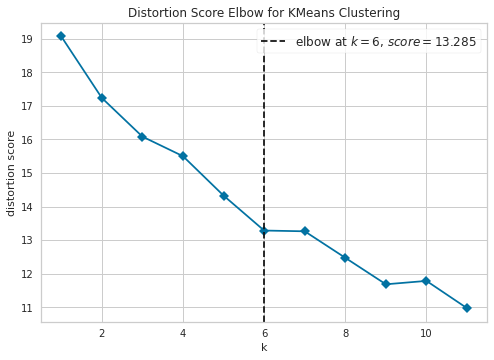

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [36]:
# Import yellowbrick wrapper for sklearn and ElbowVisualizer/Silhouette plotters
#!pip install -U yellowbrick
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
model = KMeans()

# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(1,12), timings=False, random_state=4)
visualizer.fit(toronto_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [37]:
# set number of clusters, graph isn't great for discernment but going ahead with k=6 anyway
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=4).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_merged = TorNeighdf_full

# merge toronto_grouped with TorNeighdf_full to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# remove rows with NaN as cluster label and assign int to the cluster labels rather than float
toronto_merged.dropna(axis=0, how='any', subset=['Cluster Labels'], inplace=True)
toronto_merged['Cluster Labels']= toronto_merged['Cluster Labels'].astype(int)
toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,0,Park,Food & Drink Shop,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Ethiopian Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,3,Hockey Arena,Coffee Shop,Pizza Place,Portuguese Restaurant,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,3,Coffee Shop,Bakery,Park,Pub,Breakfast Spot,Café,Theater,Gym / Fitness Center,Event Space,Restaurant
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,3,Clothing Store,Accessories Store,Furniture / Home Store,Miscellaneous Shop,Vietnamese Restaurant,Coffee Shop,Boutique,Women's Store,Distribution Center,Dim Sum Restaurant
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,3,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Café,Bank,Bar,Burrito Place,Italian Restaurant,Spa,Yoga Studio


In [38]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

### Examine Clusters

In [39]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,0,Park,Food & Drink Shop,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Ethiopian Restaurant
21,Caledonia-Fairbanks,0,Park,Women's Store,Greek Restaurant,Dance Studio,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant
35,The Danforth East,0,Park,Convenience Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Deli / Bodega
40,Downsview East,0,Park,Electronics Store,Airport,Bus Stop,Escape Room,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Deli / Bodega
49,"North Park, Maple Leaf Park, Upwood Park",0,Basketball Court,Park,Bakery,Construction & Landscaping,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
61,Lawrence Park,0,Park,Swim School,Bus Line,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Deli / Bodega,Distribution Center
64,Weston,0,Park,Convenience Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Deli / Bodega
66,York Mills West,0,Park,Flower Shop,Convenience Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Deli / Bodega
68,Forest Hill North & West,0,Park,Trail,Sushi Restaurant,Jewelry Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
83,"Moore Park, Summerhill East",0,Park,Lawyer,Restaurant,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run


**These seem to cluster together due to their most frequent venues being parks**

In [40]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Christie,1,Grocery Store,Café,Park,Baby Store,Italian Restaurant,Nightclub,Candy Store,Coffee Shop,Restaurant,Dessert Shop
46,Downsview West,1,Grocery Store,Park,Hotel,Shopping Mall,Bank,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
60,Downsview Northwest,1,Gym / Fitness Center,Athletics & Sports,Liquor Store,Discount Store,Grocery Store,Airport Food Court,Falafel Restaurant,Accessories Store,Ethiopian Restaurant,Escape Room
63,"Runnymede, The Junction North",1,Grocery Store,Brewery,Convenience Store,Bus Line,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Dessert Shop
89,"South Steeles, Silverstone, Humbergate, Jamest...",1,Grocery Store,Pizza Place,Discount Store,Liquor Store,Fried Chicken Joint,Beer Store,Pharmacy,Fast Food Restaurant,Sandwich Place,Japanese Restaurant
102,"Mimico NW, The Queensway West, South of Bloor,...",1,Sandwich Place,Discount Store,Grocery Store,Gym,Wings Joint,Bakery,Hardware Store,Fast Food Restaurant,Tanning Salon,Supplement Shop


**These seem to cluster based on grocery stores**

In [41]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,"West Deane Park, Princess Gardens, Martin Grov...",2,Bakery,Women's Store,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Event Space


In [42]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,3,Hockey Arena,Coffee Shop,Pizza Place,Portuguese Restaurant,Women's Store,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
2,"Regent Park, Harbourfront",3,Coffee Shop,Bakery,Park,Pub,Breakfast Spot,Café,Theater,Gym / Fitness Center,Event Space,Restaurant
3,"Lawrence Manor, Lawrence Heights",3,Clothing Store,Accessories Store,Furniture / Home Store,Miscellaneous Shop,Vietnamese Restaurant,Coffee Shop,Boutique,Women's Store,Distribution Center,Dim Sum Restaurant
4,Ontario Provincial Government,3,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Café,Bank,Bar,Burrito Place,Italian Restaurant,Spa,Yoga Studio
6,"Malvern, Rouge",3,Fast Food Restaurant,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
7,Don Mills North,3,Gym,Japanese Restaurant,Café,Caribbean Restaurant,Dessert Shop,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Department Store
8,"Parkview Hill, Woodbine Gardens",3,Pizza Place,Gym / Fitness Center,Gastropub,Café,Bank,Athletics & Sports,Flea Market,Intersection,Pharmacy,Pet Store
9,"Garden District, Ryerson",3,Coffee Shop,Clothing Store,Middle Eastern Restaurant,Cosmetics Shop,Japanese Restaurant,Italian Restaurant,Bubble Tea Shop,Café,Hotel,Pizza Place
10,Glencairn,3,Park,Pizza Place,Metro Station,Sushi Restaurant,Bakery,Japanese Restaurant,Donut Shop,Doner Restaurant,Dog Run,Department Store
13,Don Mills South,3,Gym,Coffee Shop,Restaurant,Bike Shop,Chinese Restaurant,Sandwich Place,Beer Store,Italian Restaurant,Sporting Goods Shop,Discount Store


**This is by far the largest cluster and seems to be mostly from pubs/restaurants/shops**

In [43]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,"Rouge Hill, Port Union, Highland Creek",4,Bar,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Event Space


In [44]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
53,Downsview Central,5,Baseball Field,Food Truck,Home Service,Department Store,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store
57,"Humberlea, Emery",5,Baseball Field,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store,Event Space
62,Roselawn,5,Garden,Home Service,Women's Store,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
101,"Old Mill South, King's Mill Park, Sunnylea, Hu...",5,Pool,Baseball Field,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store


**These appear to cluster together from having baseball fields, delis, dim sum restaurants, dog runs, and diners**